**извлечение признаков из текста на естественном языке**

кластеризатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
39,"Баскетбол : Кириленко опроверг прогнозы врачей Главная звезда российского\nбаскетбола Андрей Кириленко вернулся в строй после двухнедельного\nотсутствия, связанного с травмой правой лодыжки. О том...",sport
2787,"Компания Apple создала новую функцию, с помощью которой пользователь может очищать свой календарь от назойливого спама.\n\nСовсем недавно пользователи «яблочной» компании начали жаловаться на то, ...",tech


---

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [8]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 20 s, sys: 95.6 ms, total: 20.1 s
Wall time: 20.1 s


In [9]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [10]:
data[['text_clean']].sample(2)

,text_clean
217,львов покажут картин микеланджел декабр львов показа единствен украин графическ работ микеланджел ангел переда корреспондент нов регион
2131,напада ростов сердар азмун назва лучш молод футболист аз верс порта outsideoftheboot com сезон футболист сборн ира заня ростовчан втор мест чемпионат росс текущ сезон помог команд выйт основн сетк...


##  CountVectorizer + TF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tf = TfidfVectorizer(use_idf=True,norm='l2')
# tf = TfidfVectorizer(use_idf=False,norm='l2')

tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [13]:
len(tf.vocabulary_)

34798

## формируем датасет

In [14]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34798)

## обучаем

In [15]:
from sklearn.cluster import KMeans

In [16]:
%%time

n_clusters = len(set(data['tag']))
clust = KMeans(n_clusters=n_clusters, random_state=622 )
clust.fit(X)

CPU times: user 53.5 s, sys: 72.3 ms, total: 53.6 s
Wall time: 45.7 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=622, tol=0.0001, verbose=0)

In [17]:
data['cluster'] = clust.labels_

## тестируем

In [18]:
from matplotlib import pyplot as plt

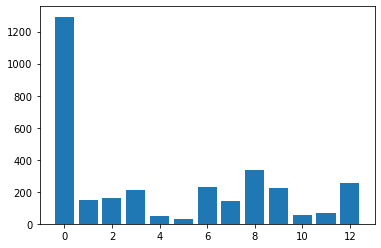

In [19]:
# размеры кластеров
b = [ (data['cluster']==c).sum() for c in range(n_clusters) ]
plt.bar(range(len(b)),b)
plt.show()

In [20]:
data[ data['cluster']==0 ][['text','tag']].sample(10)

,text,tag
1780,"Промышленное производство в Китае выше прогноза\n\nСогласно данным, опубликованным сегодня Национальным бюро статистики Китая, промышленное производство в Поднебесной увеличилось в ноябре, в годов...",economics
2747,"10:15 13 декабря 2016 4\n\nНовые рубли станут прозрачными и начнут светиться Фото: Вадим Ахметов © URA.Ru\n\nГознак приобрел несколько новых патентов, позволяющих усовершенствовать защиту купюр от...",science
886,"""Я хочу платить актерам зарплату"". Проблемы белорусского кино глазами режиссера Влады Сеньковой\n\n29 ноября 2016 в 13:03\n\nАнна Ефременко / Фото: Дмитрий Брушко / AFISHA.TUT.BY\n\n«Летом в Берли...",culture
1113,Криштиану Роналду может на 6 лет сесть в тюрьму\n\n7 декабря 2016 в 9:22\n\nEurosport.ru\n\nИспанский суд может открыть дело в отношении Роналду в ближайшее время. Как сообщает Mundo Deportivo со ...,sport
767,"Кукурузный лабиринт для туристов планируют создать в Горецком районе\n\n7 декабря 2016 в 8:19\n\nСергей Кулягин, БЕЛТА\n\nАгропарк «Кукурузный лабиринт «Кукулэнд» планируют создать в Горецком райо...",social
2510,Созданный российскими разработчиками человекоподобный робот «Федор» займет место второго пилота на космическом корабле «Федерация». Об этом сообщил генконструктор НПО «Андроидная техника» Алексей ...,science
352,"За газовый вопрос взялись профильные комитеты Верховной Рады и Госдумы\nКомитет по энергетике, транспорту и связи Государственный Думы Российской\nФедерации и комитет по вопросам топливно-энергети...",politics
131,"Организаторы Australian Open ждут Мартину Хингис... Open Пол Макнами\nсообщил журналистам, что будет рад предоставить Wild card экс-первой\nракетке мира Мартине Хингис, если швейцарская теннисистк...",sport
279,"""Уралсвязьинформ"" готов к переходу на новые коды... Министерства\nинформационных технологий и связи РФ ""Об изменении закрепления кодов\nгеографически определяемых зон нумерации и кодов географичес...",tech
1015,"Ермошина: изменить избирательную систему можно без проведения референдума\n\n30 ноября 2016 в 14:43\n\nСергей Королевич, БелаПАН\n\nИзменить избирательную систему Беларуси можно без проведения реф...",politics


In [21]:
data[ data['cluster']==1 ][['text','tag']].sample(10)

,text,tag
1864,"Избранный президент США Дональд Трамп в ходе телефонного разговора с главным кандидатом на пост госсекретаря Миттом Ромни сообщил, что Ромни не будет занимать эту должность.\n\nПосле разговора экс...",politics
1922,"Президент США Барак Обама заключил договор аренды офисного помещения в здании штаб-квартиры Всемирного фонда дикой природы (WWF) в Вашингтоне, пишет газета Washington Post.\r\n\r\nWWF, как отмечае...",politics
416,Раскрыты личные траты Трампа на президентскую гонку\n\n9 декабря 2016 в 17:02\n\nLenta.ru\n\nИзбранный президент США Дональд Трамп потратил на свою избирательную кампанию 66 миллионов долларов из ...,politics
1423,"ВАШИНГТОН, 13 декабря. /Корр. ТАСС Антон Чудаков/. Аппарат директора национальной разведки США Джеймса Клэппера не поддерживает выводов Центрального разведывательного управления (ЦРУ), согласно ко...",politics
1836,"Дональд Трамп решил отложить до января свою первую пресс-конференцию в качестве избранного президента США, на которой он объявит об уходе из бизнеса, сообщает телекомпания CNN. Состояние Трампа оц...",politics
1958,"Об этом говорится в выпуске британской деловой газеты во вторник, 13 декабря. Financial Times считает, что миллиардер переписал правила политики своей страны.\n\nТеперь президент, являющийся специ...",politics
451,"Обама признал роль ошибок США в зарождении ИГИЛ\n\n7 декабря 2016 в 6:48\n\nРБК\n\nПрезидент США Барак Обама в своей речи о проблемах безопасности признал, что зарождению и росту террористической ...",politics
1446,"Трамп отложил до января официальное заявление о планах по уходу из бизнеса\n\nМОСКВА, 13 дек — РИА Новости. Избранный президент США Дональд Трамп перенес на январь официальное объявление о планах ...",politics
1835,"Избранный президент США Дональд Трамп на месяц перенес пресс-конференцию, посвященную его планам выйти из бизнеса на период президентства. Ранее мероприятие было анонсировано на четверг.\n\n""Объяв...",politics
1944,"Избранный президент США Дональд Трамп позитивно воспринял новость о том, что пересчет голосов в штате Висконсин подтвердил его победу.\n\n«Окончательное голосование в Висконсине завершено, и что в...",politics


In [22]:
data[ data['cluster']==3 ][['text','tag']].sample(10)

,text,tag
506,"В Гродно три человека госпитализировали после неудачного поворота налево\n\n10 декабря 2016 в 12:33\n\nAUTO.TUT.BY\n\nТри человека, в том числе 14-летняя девочка, госпитализированы после ДТП, кото...",incident
2323,"Сотрудница межмуниципального управления МВД России «Серпуховское», находившаяся за рулем в пьяном виде, насмерть сбила двоих человек в Подмосковье.\n\nПо информации главного управления МВД по Моск...",incident
2261,Двадцать военнослужащих пострадали в результате взрыва на военной базе в районе города Ульсан в Южной Корее.\n\nПятеро пострадавших были госпитализированы. Остальные раненые смогли добраться до бо...,incident
552,"Легковушка сбила шестилетнего ребенка на пешеходном переходе в Волковыске\n\n4 декабря 2016 в 11:33\n\nAUTO.TUT.BY\n\nЛегковушка на пешеходном переходе сбила шестилетнего ребенка в Волковыске, пиш...",incident
563,В Витебске лоб в лоб столкнулись милицейский автомобиль и медпомощь\n\n2 декабря 2016 в 15:50\n\nAUTO.TUT.BY\n\nДТП произошло 2 декабря в первом часу дня возле Кировского моста в Витебске. Столкну...,incident
2379,"Появилось видео момента наезда водителя Mercedes на двух школьниц на западе Москвы. На кадрах видно, как иномарка сносит детей прямо на пешеходном переходе.\n\nРанее сообщалось, что инцидент произ...",incident
2378,"Теги: полиция ДТП москва\n\nНа западе Москвы водитель Gelandewagen сбил двух девочек, переходивших дорогу по пешеходному переходу. Виновник ДТП скрылся с места происшествия. Дети получили небольши...",incident
2331,В результате аварии пострадали оба водителя.В Ростовской области на трассе М-4 «Дон» столкнулись два грузовика «Вольво».ДТП произошло 12 декабря около 20 часов на 1073 километре автодороги.В насто...,incident
556,Неизвестные застрелили двоих посетителей кафе в Стокгольме\n\n3 декабря 2016 в 18:51\n\nLenta.ru\n\nДепартамент полиции шведской столицы Стокгольма начал расследование двойного убийства на севере ...,incident
2282,"Сложные метеоусловия стали причиной ДТП на кузбасской трассе.\n\nПо сообщению пресс-службы областной ГИБДД, в аварии на автомагистрали «Кемерово – Ленинск-Кузнецкий» поврежедно 8 автомобилей. Такж...",incident
